## SelectFromModel

sklearn在Feature selection模块中内置了一个SelectFromModel，该模型可以通过Model本身给出的指标对特征进行选择，其作用与其名字高度一致，select （feature） from model。
SelectFromModel 是一个通用转换器,其需要的Model只需要带有`conef_`或者`feature_importances`属性,那么就可以作为SelectFromModel的Model来使用. 如果相关的``coef_`` 或者 `featureimportances` 属性值低于预先设置的阈值，这些特征将会被认为不重要并且移除掉。除了指定数值上的阈值之外，还可以通过给定字符串参数来使用内置的启发式方法找到一个合适的阈值。可以使用的启发式方法有 mean 、 median 以及使用浮点数乘以这些（例如，0.1*mean ）。


**根据基础学习的不同，在estimator中有两种选择方式**

第一种是基于L1的特征选择，使用L1正则化的线性模型会得到稀疏解，当目标是降低维度的时候，可以使用sklearn中的给予L1正则化的线性模型，比如LinearSVC，逻辑回归，或者Lasso。但是要注意的是：在 SVM 和逻辑回归中，参数 C 是用来控制稀疏性的：小的 C 会导致少的特征被选择。使用 Lasso，alpha 的值越大，越少的特征会被选择。

第二种是给予Tree的特征选择，Tree类的算法包括决策树，随机森林等会在训练后，得出不同特征的重要程度，我们也可以利用这一重要属性对特征进行选择。


**但是无论选择哪一种学习器,我们都要记住的是我们的特征选择的最终标准应当是选择最好的特征,而非必须依照某种方法进行选择**
## 几个重要的参数，属性，方法

 - threshold ： 阈值，string, float, optional default None
     - 可以使用：median 或者 mean 或者 1.25 * mean 这种格式。
     - 如果使用参数惩罚设置为L1，则使用的阈值为1e-5，否则默认使用用mean
 - prefit ：布尔，默认为False，是否为训练完的模型，（注意不能是cv，GridSearchCV或者clone the estimator得到的），如果是False的话则先fit，再transform。
 
 - threshold_ ：采用的阈值
 
## 简单的示例：
### 使用L1进行特征选择

In [42]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

# Load the boston dataset.
load_iris = load_iris()
X, y = load_iris['data'], load_iris['target']
print("X 共有 %s 个特征"%X.shape[1])

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc,prefit=True)
X_new = model.transform(X)
print("X_new 共有 %s 个特征"%X_new.shape[1])

X 共有 4 个特征
X_new 共有 3 个特征


### 基于树的特征选择

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier().fit(X,y)
print("clf.feature_importances_ :",clf.feature_importances_)

model_2 = SelectFromModel(clf,prefit=True)
X_new_2 = model_2.transform(X)
print("X_new_2 共有 %s 个特征"%X_new_2.shape[1])

model_3 = SelectFromModel(clf,prefit=True,threshold=0.15)
X_new_3 = model_3.transform(X)
print("model的阈值为 :%s"%model_3.threshold)
print("X_new_3 共有 %s 个特征"%X_new_3.shape[1])

clf.feature_importances_ : [0.14016636 0.06062787 0.47708914 0.32211664]
X_new_2 共有 2 个特征
model的阈值为 :0.15
X_new_3 共有 2 个特征


### 更多的示例
#### 特征的选取并不一定代表着性能的提升,这一点在所有的特征选择中是一致的

我对sklearn中的例子(Feature selection using SelectFromModel and LassoCV),稍加改造,就可以一见分毫

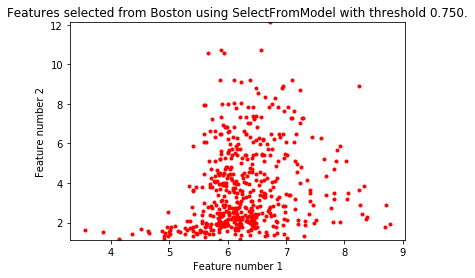

In [43]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Load the boston dataset.
boston = load_boston()
X, y = boston['data'], boston['target']

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.0)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]



def GetCVScore(estimator,X,y):
    from sklearn.model_selection import  cross_val_score
    nested_score = cross_val_score(clf, X=X, y=y, cv=5)
    nested_score_mean = nested_score.mean()
    return nested_score_mean

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.

nested_scores = []
n_features_list = []
while n_features > 2:
    sfm.threshold += 0.01
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

    nested_score = GetCVScore(estimator=clf, X=X_transform, y=y)
    nested_scores.append(nested_score)
    n_features_list.append(n_features)
    # print("nested_score: %s"%nested_score)
    # print("n_features: %s"%n_features)
    # print("threshold: %s"%sfm.threshold)

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1] 
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

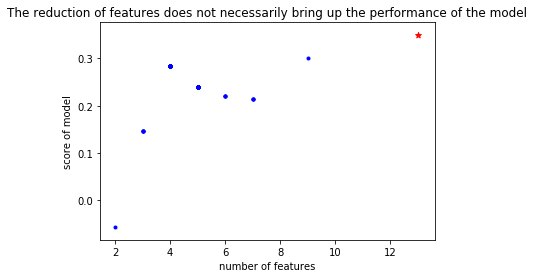

In [45]:
plt.scatter(n_features_list,nested_scores,c=u'b',marker=u'.',label = 'Selected')
plt.scatter(X.shape[1],GetCVScore(estimator=clf, X=X, y=y),c=u'r',marker=u'*',label = 'old feature')
plt.title("The reduction of features does not necessarily bring up the performance of the model")
plt.xlabel("number of features")
plt.ylabel("score of model")
plt.show()

前面的第一个例子,展示了如何同时使用selectFromModel and Lasso,而后面我所添加的内容,则展示了:The reduction of features does not necessarily bring up the performance of the model

特征选取并不一定升:所有特征有效的情况下,去除的特征只能带来模型性能的下降,即使不是全部有效很多时候,低重要程度的特征也并不一定代表着一定会导致模型性能的下降,因为某种度量方式并不代表着该特征的最终效果,很多时候我们的度量方式,往往只是一个参考而已.


## 参考

 - [sklearn官方文档:Univariate Feature Selection](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py)
 - [sklearn官方文档:Feature selection using SelectFromModel and LassoCV](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-boston-py)
 - [sklearn ApacheCN 官方翻译](http://sklearn.apachecn.org/cn/0.19.0/modules/feature_selection.html)
 
## 扩展阅读:
 - [方差过滤](http://blog.csdn.net/fontthrone/article/details/78997449)
 - [单变量特征选择](http://blog.csdn.net/fontthrone/article/details/78997470)
 - [递归式特征选择](http://blog.csdn.net/fontthrone/article/details/79004874)
 - [机器学习常用数据集](http://blog.csdn.net/fontthrone/article/details/78748129)